In [215]:
from selenium import webdriver
import time
import re
import datetime
import os
from bs4 import BeautifulSoup
import numpy as np
import itp_creds
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn import metrics
from sklearn.cluster import KMeans

In [2]:
geckoDriverPath = '/Users/matthewmitchell/Documents/Projects/Tools/Python/Scraping/geckodriver'

## Open Browser and Login

In [221]:
driver = webdriver.Firefox(executable_path=geckoDriverPath)
driver.get("https://itp.nyu.edu/camp2023/people")

In [222]:
def sim_type(string, element):
    for i in string:
        element.send_keys(i)
        pause = np.random.uniform(0,0.1)
        time.sleep(pause)

## For this to work, you must create a file "itp_creds.py"
The file should look like this:

```{python}
u = "Your username/email"
p = "Your Password"
```

> **Note:**  
You can also manually enter these and skip to "Cache people page"

In [223]:
email_input = driver.find_element_by_id("signin_email")
sim_type(itp_creds.u, email_input)

In [224]:
password_input = driver.find_element_by_id("signin_password")
sim_type(itp_creds.p, password_input)

In [225]:
signin_button = driver.find_element_by_xpath('//button[text()="Sign In"]')

In [226]:
signin_button.click()

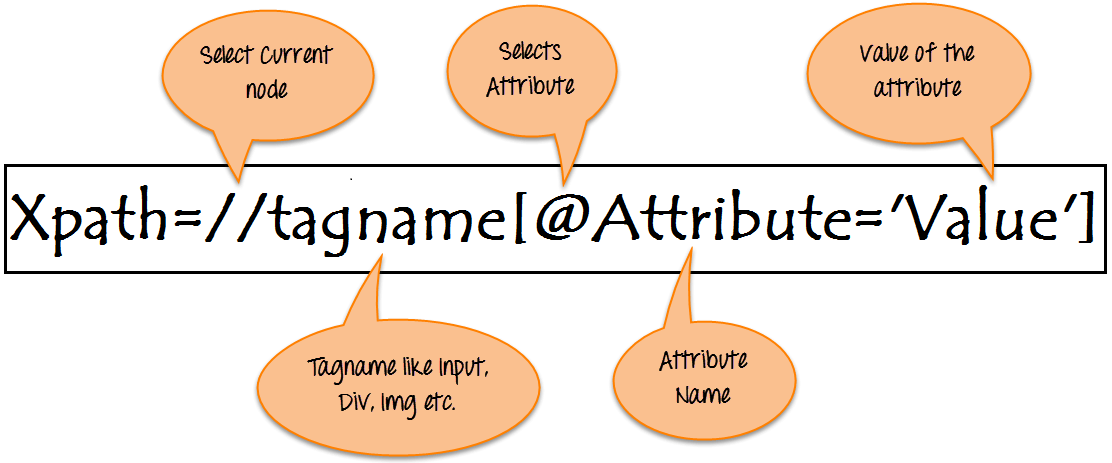

## Cache People Page

In [62]:
driver.get("https://itp.nyu.edu/camp2023/people")

In [63]:
cur_html = driver.page_source

In [64]:
cur_url = driver.current_url

In [12]:
#Close the Browser
driver.close()

## Save Current HTML to Disk

In [13]:
## Create Filename:
def sub_all(pattern, sub_str, start_str):
    update = re.sub(pattern, sub_str, start_str)
    if update != start_str:
        #recurse!
        return sub_all(pattern, sub_str, update)
    else:
        return update

cleaned_url = sub_all("[:/.]","-", cur_url.strip("https://"))
print("Finalized updated:")
print(cleaned_url)

Finalized updated:
itp-nyu-edu-camp2023-people


In [14]:
root_dir = os.getcwd()

In [15]:
def snapshot_page_html(html, url):
    #Clean URL For SubFolder Creation
    cleaned_url = sub_all("[:/.]","-", cur_url.strip("https://"))
    
    #Get CWD
    root_dir = os.getcwd()
    
    #Create SubFolder (if Necessary)
    os.chdir(root_dir)
    if os.path.isdir(cleaned_url):
        os.chdir(cleaned_url)
    else:
        os.mkdir(cleaned_url)
        os.chdir(cleaned_url)
        
    #Record Snapshot Time
    time_now = datetime.datetime.now().strftime("%m-%d-%y_%H%M%p")
    
    #Create Filename
    filename = "WebPageSnapshot_{}.html".format(time_now)
    
    #Write HTML to File
    if os.path.isfile(filename):
        print("File already exists.")
        os.chdir(root_dir)
        return None
    with open(filename, "w") as f:
        f.write(cur_html)
        
    #Return to Original Directory
    os.chdir(root_dir)

In [16]:
os.chdir(root_dir)

In [69]:
os.getcwd()

'/Users/matthewmitchell/Documents/ITP_Camp/PeopleCluster'

In [70]:
os.listdir()

['FirstPeopleClustering.csv',
 'ITP_People_Scraper.ipynb',
 '__pycache__',
 'itp-nyu-edu-camp2023-people',
 'geckodriver.log',
 '.gitignore',
 '.ipynb_checkpoints',
 '.git',
 'itp_creds.py']

### List All Snapshots That You Have Locally

In [67]:
snapshot_page_html(cur_html, cur_url)

In [68]:
sorted(os.listdir('itp-nyu-edu-camp2023-people'))

['WebPageSnapshot_06-07-23_2244PM.html',
 'WebPageSnapshot_06-07-23_2245PM.html',
 'WebPageSnapshot_06-07-23_2246PM.html',
 'WebPageSnapshot_06-07-23_2247PM.html',
 'WebPageSnapshot_06-07-23_2305PM.html',
 'WebPageSnapshot_06-07-23_2321PM.html',
 'WebPageSnapshot_06-07-23_2322PM.html',
 'WebPageSnapshot_06-08-23_1117AM.html',
 'WebPageSnapshot_06-08-23_1145AM.html',
 'WebPageSnapshot_06-11-23_1901PM.html']

## Above Could Now Be Deployed on Regulard Crontab Job

## Sample Parse

In [21]:
soup = BeautifulSoup(cur_html)

In [240]:
import sys

In [22]:
people_divs = soup.find_all("div", {"class": "userListItem"})
print(len(people_divs))

people = []
for div in people_divs:
    profile_info = div.find_all("p", {"class":"profileInfo"})[0]
    name = profile_info.get_text().strip().split("   ")[0]
    shortAbout = profile_info.find("span", {"class":"shortAbout"})
    shortAbout = shortAbout.get_text()
    people.append((name, shortAbout))
people[:5]

258


[('Abby Schmiedt', ''),
 ('Ada Varriale (she/her)',
  'from italy, living in Amsterdam and doing a master in experimental publishing in Rotterdam(xpub.nl if...'),
 ('Addison Worthington', ''),
 ('Adeline Setiawan', ''),
 ('Adnan', '')]

In [23]:
df = pd.DataFrame(people)
print(len(df))
df.columns = ['Name','shortAbout']
df.head()

258


,Name,shortAbout
0,Abby Schmiedt,
1,Ada Varriale (she/her),"from italy, living in Amsterdam and doing a ma..."
2,Addison Worthington,
3,Adeline Setiawan,
4,Adnan,


## Filter Out Null Bios....

In [24]:
temp = df.shortAbout == ""
temp.value_counts()

True     171
False     87
Name: shortAbout, dtype: int64

In [25]:
dff = df[df.shortAbout!=""]#Filtered DF
corpus = list(dff.shortAbout)
print(len(corpus))
corpus[:5]

87


['from italy, living in Amsterdam and doing a master in experimental publishing in Rotterdam(xpub.nl if...',
 'Administrative Aide II',
 "I'm a professional editor and writer, semi-professional crafter, and deeply amateur game developer.",
 "Hi campers! I'm a lecturer at UMD College Park, where I do graduate classes on interaction design and...",
 "Hello! I'm a project manager, and budding creative technologist, at a retail tech lab (Brand Experience..."]

## TF-IDF on shortAbout Corpus
https://stackoverflow.com/questions/8897593/how-to-compute-the-similarity-between-two-text-documents

In [26]:
vect = TfidfVectorizer(min_df=1, stop_words="english")                                                                                                                                                                                                   
tfidf = vect.fit_transform(corpus)                                                                                                                                                                                                                       
pairwise_similarity = tfidf * tfidf.T

In [27]:
pairwise_similarity.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## Visualizing Pairwise Similarities

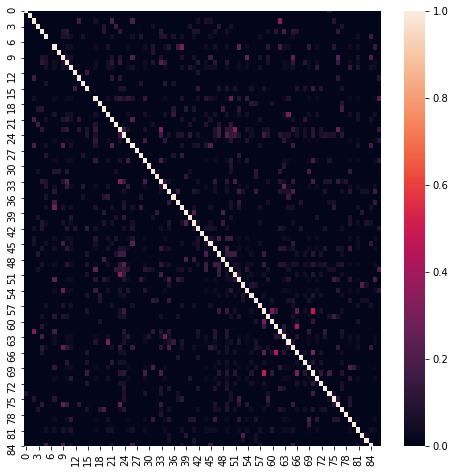

In [28]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(pairwise_similarity.toarray())

## Basic Clustering with KMeans

Some references:
* [Basic Tutorial from Kaggle](https://www.kaggle.com/code/jbencina/clustering-documents-with-tfidf-and-kmeans_)
* [SkLearn Examples](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html)

In [29]:
evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

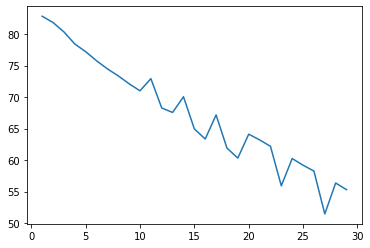

In [30]:
#This has a random seed - you can rerun with slightly different results
cluster_inertias = []
cluster_sizes = []
for i in range(1,30):
    kmeans = KMeans(
        n_clusters=i,
        max_iter=100,
        n_init=1,
    ).fit(tfidf)
    
    cluster_inertias.append(kmeans.inertia_)
    cluster_sizes.append(i)
plt.plot(cluster_sizes, cluster_inertias)

In [31]:
n_clusters = 15 #heuristically determined from plot above...no real elbow present here.
clusters = KMeans(
        n_clusters=n_clusters,
        max_iter=100,
        n_init=1,
    ).fit_predict(tfidf)

In [32]:
clusters

array([14,  2,  2,  5,  0,  8,  2,  1, 10,  2,  8,  2, 12,  0,  2, 12,  2,
        0,  0, 13,  3,  2,  5,  0,  0,  0,  2,  2, 13,  8,  2, 10,  6,  8,
        8, 11,  3,  1,  1,  6,  5,  6, 12,  2,  2,  2,  8,  0,  6,  4,  0,
        0, 13,  7,  0,  7, 11,  2,  4,  1,  4,  9,  1,  9,  3, 11,  9,  2,
       12, 10,  4,  1, 12, 11, 14, 13,  0,  5,  8, 10, 10,  2,  7, 11,  2,
       13,  0], dtype=int32)

In [33]:
dff['Cluster'] = clusters
dff.head()

/Users/matthewmitchell/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Name,shortAbout,Cluster
1,Ada Varriale (she/her),"from italy, living in Amsterdam and doing a ma...",14
5,Adrian Mandeville,Administrative Aide II,2
10,Alanna Okun,"I'm a professional editor and writer, semi-pro...",2
11,Alex L,Hi campers! I'm a lecturer at UMD College Park...,5
15,Alexandra Zelcer,"Hello! I'm a project manager, and budding crea...",0


In [34]:
dff.Cluster.value_counts()

2     18
0     13
8      7
1      6
10     5
12     5
13     5
11     5
5      4
6      4
4      4
3      3
7      3
9      3
14     2
Name: Cluster, dtype: int64

## Model 2: LDA

In [35]:
import lda

In [36]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000,
                                stop_words='english');
tf = tf_vectorizer.fit_transform(corpus)

In [41]:
n_topics = 15
model = lda.LDA(n_topics=n_topics, n_iter=1500, random_state=1);
model.fit(tf);

topic_word = model.topic_word_  # model.components_ also works
vocab = tf_vectorizer.get_feature_names();

INFO:lda:n_documents: 87
INFO:lda:vocab_size: 102
INFO:lda:n_words: 346
INFO:lda:n_topics: 15
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -3375
INFO:lda:<10> log likelihood: -2006
INFO:lda:<20> log likelihood: -1966
INFO:lda:<30> log likelihood: -1966
INFO:lda:<40> log likelihood: -1929
INFO:lda:<50> log likelihood: -1933
INFO:lda:<60> log likelihood: -1996
INFO:lda:<70> log likelihood: -1994
INFO:lda:<80> log likelihood: -1996
INFO:lda:<90> log likelihood: -1955
INFO:lda:<100> log likelihood: -1949
INFO:lda:<110> log likelihood: -1955
INFO:lda:<120> log likelihood: -1932
INFO:lda:<130> log likelihood: -1924
INFO:lda:<140> log likelihood: -1961
INFO:lda:<150> log likelihood: -1927
INFO:lda:<160> log likelihood: -1936
INFO:lda:<170> log likelihood: -1951
INFO:lda:<180> log likelihood: -1973
INFO:lda:<190> log likelihood: -1967
INFO:lda:<200> log likelihood: -2011
INFO:lda:<210> log likelihood: -1938
INFO:lda:<220> log likelihood: -1973
INFO:lda:<230> log likelihood: -1932
INFO:ld

#### Cluster Word Clouds (From LDA)

In [38]:
topic_word = model.topic_word_  # model.components_ also works
vocab = tf_vectorizer.get_feature_names();

n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: working video currently visual interactive mapping installations electronic art
Topic 1: manager digital lab educator technical operations focus film director
Topic 2: music better hi tech world focus years hello graphic
Topic 3: designer based specializing product technologist ve years music filmmaker
Topic 4: things love starting ask degree technician fabrication just write
Topic 5: design professor currently associate interaction college technology graphic filmmaker
Topic 6: work focuses film ima maker brooklyn hi professional background
Topic 7: media artist art university mixed focus director doing editor
Topic 8: trying amateur writer interested projection doing editor computer electronic
Topic 9: itp director ima assistant low res xr camp graphic
Topic 10: artist sound creating performance researcher coder installations generative years
Topic 11: making hello generative web bring create short like hi
Topic 12: engineer software writer photographer musician years artist 

In [43]:
from wordcloud import WordCloud
import math

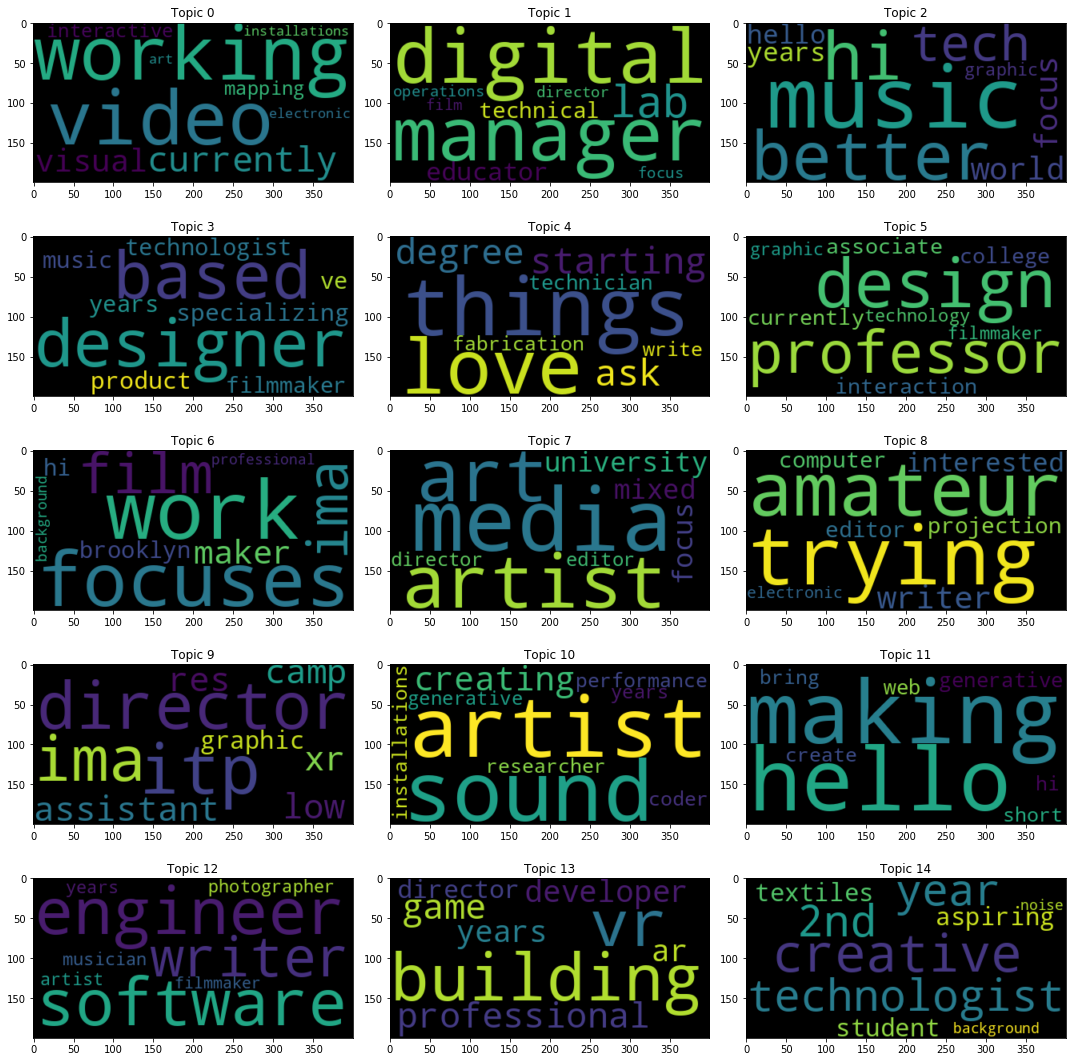

In [46]:
ncols = 3
nrows = math.ceil(n_topics / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(15,15)) #15 topics broken out 3 by 5
fig.tight_layout()
for i, topic_dist in enumerate(topic_word):
    topic_words = list(np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words):-1])
    topic_words = ' '.join(topic_words)
    row = i//ncols
    col = i%ncols
    ax = axes[row, col]
    wordcloud = WordCloud().generate(topic_words)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('Topic {}'.format(i))
plt.tight_layout()

## Preview and Save Clusters

In [47]:
dff.head()

,Name,shortAbout,Cluster
1,Ada Varriale (she/her),"from italy, living in Amsterdam and doing a ma...",14
5,Adrian Mandeville,Administrative Aide II,2
10,Alanna Okun,"I'm a professional editor and writer, semi-pro...",2
11,Alex L,Hi campers! I'm a lecturer at UMD College Park...,5
15,Alexandra Zelcer,"Hello! I'm a project manager, and budding crea...",0


In [48]:
dff[dff["Name"].str.contains("Matt")]

,Name,shortAbout,Cluster
161,Matt Mitchell,Hey there I'm Matt! I love tinkering and build...,11


In [49]:
dff[dff["Cluster"]==11]

,Name,shortAbout,Cluster
111,Jaclyn McKay,Visual designer working on all things interact...,11
161,Matt Mitchell,Hey there I'm Matt! I love tinkering and build...,11
195,Riho Hagi,I'm a creative technologist and software engin...,11
217,Shiva Viswanathan,Keyboard person. Gamer. Designer?,11
241,Weber Wong,"like coffee / coffee shops, history, poetry, s...",11


In [51]:
pd.options.display.max_rows = None

In [54]:
dff = dff.sort_values(by='Cluster')
dff

,Name,shortAbout,Cluster
251,Yilin Ye,"cultural practitioner, media & filmmaker, like...",0
79,Efrat Levy,"I’m an illustrator, graphic designer and art d...",0
74,Dror Margalit,I am a creative technologist and 2nd-year ITP ...,0
66,David Nuff,"(Come back later and write this again, but in ...",0
63,David Clark,"I am a media artist and writer from Halifax, N...",0
127,Juan Parada,Former ITP student ('97) and now an Associate ...,0
135,Katherine Moriwaki (she/her),"Currently Associate Professor of Media Design,...",0
82,Elyana,Landscape architect turned self-taught digital...,0
146,Lily Crandall,"Incoming 2nd year ITP student & lover of yarn,...",0
157,Mary Mark,I am a little bit of everything: performer/cho...,0


In [55]:
dff.to_csv("FirstPeopleClustering.csv",index=False)

## Network Visualization with TSNE

In [ ]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(corpus, clusters)

## Adding User Names to Cluster Diagram

## SlackBot Integration...

### V2 - Scraping People's Sign Up Sessions

...better clustering method / judgement of interests vs backgrounds...
Jaccard Index may be appropriate metrics

In [231]:
#Pieces from above...eventually to be integrated into class..
#Open Browser
#Sign In
#Return to People Page
# Get People URLs
soup = BeautifulSoup(driver.page_source)
people_divs = soup.find_all("div", {"class": "userListItem"})
print(len(people_divs))

# people = []
# for div in people_divs:
#     profile_info = div.find_all("p", {"class":"profileInfo"})[0]
#     name = profile_info.get_text().strip().split("   ")[0]
#     shortAbout = profile_info.find("span", {"class":"shortAbout"})
#     shortAbout = shortAbout.get_text()
#     people.append((name, shortAbout))
# people[:5]

# Go to First
# Investigate / Develop Code

# Return to People page (ideally in a believable manner; back, back)

# Iterate....with appropriate time delays...

260


In [232]:
p_div = people_divs[0]

In [233]:
link = p_div.find_all("a")[0]
link.get('href')

'user/140'

In [235]:
user_page = "https://itp.nyu.edu/camp2023/" + link.get('href')
driver.get(user_page)

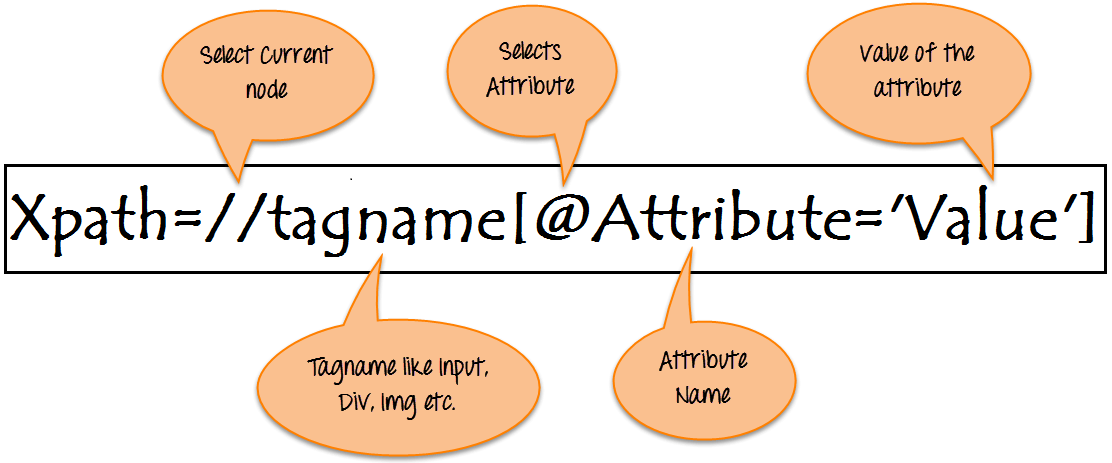

In [87]:
sessions_attending_tab = driver.find_element_by_xpath("//div[@id='tabAttending']")

In [88]:
sessions_attending_tab.click()

In [91]:
sessions_attending_list = driver.find_element_by_xpath("//div[@id='calendarListAttending']")

In [97]:
soup = BeautifulSoup(sessions_attending_list.get_attribute('innerHTML'))

In [165]:
previous_sessions = soup.find(id="previousSessionsList")
current_sessions = soup.find(id="currentSessionsList")

In [166]:
current_sessions = soup.find(id="currentSessionsList")

In [167]:
len(current_sessions.findAll("div", id=re.compile("sessionListID.*")))

30

In [168]:
len(previous_sessions.findAll("div", id=re.compile("sessionListID.*")))

11

In [169]:
sessions_list = previous_sessions.findAll("div", id=re.compile("sessionListID-\d*Attending"))
print(len(sessions_list))

sessions_list = current_sessions.findAll("div", id=re.compile("sessionListID-\d*Attending"))
print(len(sessions_list))

11
30


In [204]:
people_divs[37]

<div class="userListItem" data-role="ai" data-searchable="bonnie pham|bonnie|pham" id="userListID-236">
<p class="profileImage"><a href="user/236"><img alt="User profile image" height="40" onerror="missingProfileImage(this);" src="images/profile_photos/small/user_236.png?r=423766" width="40"/></a></p>
<p class="profileInfo">
<a href="user/236">
                Bonnie Pham                            </a>
<span class="userTag userCamper">Camper</span> <br/>
<span class="shortAbout">aspiring creative coder, software engineer from toronto</span>
</p>
<div class="clear"></div>
</div>

## Finding People Divs With Selenium Driver & XPath

In [209]:
people_div_elements = driver.find_elements_by_xpath("//div[@class='userListItem']")
print(len(people_divs))
print(len(people_div_elements))

258
260


#### Scrolling to an Element

In [210]:
element = people_div_elements[37]
driver.execute_script("arguments[0].scrollIntoView();", element)

In [212]:
datetime.datetime.now().strftime("%m-%d-%y_%H%M%p")

'06-11-23_2215PM'

In [213]:
def parse_all_user_rsvps():
    driver.get("https://itp.nyu.edu/camp2023/people")
    cur_html = driver.page_source
    soup = BeautifulSoup(cur_html)
    people_divs = soup.find_all("div", {"class": "userListItem"})
    time.sleep(np.random.uniform(1,5))
    user_dict = []
    for p_div in people_divs:
        try:
            link = p_div.find_all("a")[0]
            user_page = "https://itp.nyu.edu/camp2023/" + link.get('href')
            #Go to user's page
            driver.get(user_page)
            #Parse User Page
            user_sessions = parse_user_sessions(driver)

            #User Name
            soup = BeautifulSoup(driver.page_source)
            user_name = soup.find_all('h1')[-1].text.strip()

            user_dict[user_name] = user_sessions
        except Exception as e:
            print("Hit error: {}".format(e))
            print("Creating temporary save of user_dicts.")
            time_now = datetime.datetime.now().strftime("%m-%d-%y_%H%M%p")
            filename = "UserSessionDicts_Temp_{}.pickle".format(time_now)
            with open(filename, 'wb') as handle:
                pickle.dump(user_dict, handle, protocol=pickle.HIGHEST_PROTOCOL) 
        
        time.sleep(np.random.uniform(10,30))
        #Return to main page
        driver.get("https://itp.nyu.edu/camp2023/people")
    time_now = datetime.datetime.now().strftime("%m-%d-%y_%H%M%p")
    filename = "UserSessionDicts_Complete_{}.pickle".format(time_now)
    with open(filename, 'wb') as handle:
        pickle.dump(user_dict, handle, protocol=pickle.HIGHEST_PROTOCOL) 
    return user_dict

In [184]:
def parse_session(session):
    session_title = session.find('a').text
    session_id = int(session.find('a').get('href').split('/')[-1])
    session_info = session.find(class_="sessionInfo").text
    session_leader = re.findall(".*Leaders:(.*)", session_info)[0].strip()
    session_time = session_info.split("\n")[1]
    session_right_column = session.find(class_="sessionRightColumn")
    session_tags = session_right_column.find(class_="sessionTags")
    sessionRSVPs = session_right_column.find(class_="sessionRSVPs")
    session_dict = {}
    session_dict['title'] = session_title
    session_dict['tags'] = [tag.text for tag in session_tags.find_all('a')]
    session_dict['popularity'] = re.findall("(\d*) RSVPs.*?", sessionRSVPs.text)
    session_dict['session_leader'] = session_leader
    session_dict['session_time'] = session_time
    session_dict['id'] = session_id
    return session_dict

In [220]:
def parse_user_sessions(driver):
    #Move Tabs
    sessions_attending_tab = driver.find_element_by_xpath("//div[@id='tabAttending']")
    sessions_attending_tab.click()
    
    time.sleep(np.random.uniform(1,4)) #Brief Pause
    sessions_attending_list = driver.find_element_by_xpath("//div[@id='calendarListAttending']") 
    user_sessions = []
    soup = BeautifulSoup(sessions_attending_list.get_attribute('innerHTML'))
    
    previous_sessions = soup.find(id="previousSessionsList")
    current_sessions = soup.find(id="currentSessionsList")
    
    sessions_list = previous_sessions.findAll("div", id=re.compile("sessionListID-\d*Attending"))
    for session in sessions_list:
        user_sessions.append(parse_session(session))
#     user_sessions = user_sessions[::-1]
    
    sessions_list = current_sessions.findAll("div", id=re.compile("sessionListID-\d*Attending"))
    for session in sessions_list:
        user_sessions.append(parse_session(session))
    return user_sessions

In [217]:
user_dict = parse_all_user_rsvps() #Parse Dictionary of User RSVPs for All Users and Store.

Hit error: sleep length must be non-negative
Creating temporary save of user_dicts.


KeyboardInterrupt: 

## DEV WORK BELOW

In [236]:
user_sessions = parse_user_sessions(driver)
print(len(user_sessions))

41


In [237]:
soup = BeautifulSoup(driver.page_source)
user_name = soup.find_all('h1')[-1].text.strip()

user_name

'Abby Schmiedt'

In [238]:
pd.DataFrame(user_sessions)

,title,tags,popularity,session_leader,session_time,id
0,Class 1: Mastering Precision: achieving accura...,"[#drawing, #illustration]",[29],Kevin Lee,4-6:30pm,34
1,TOUCHDESIGNER: CLASS 1 – BASIX,"[#code, #graphics, #3D, #visuals, #art]",[75],Armon Naeini • viola he (they/any),6:30-8:30pm,79
2,Intro to Blender,"[#3d modeling, #3d, #blender, #asset creation]",[60],Zoe Margolis,4-5pm,14
3,Project Documentation 101,"[#photography, #document, #portfolio]",[19],Alan Winslow,5-6pm,124
4,🕶 Conceptual Challenges of Designing for XR,"[#AR, #XR, #Spatial Interaction, #Spatial Comp...",[51],Boris • Gregor,7-8:30pm,96
5,Shop Safety,"[#shop, #safety training, #mandatory]",[8],Priyanka M,5-6pm,201
6,ALL CAMP: Friday Fireside Social,[],[75],ITP Camp,6-7pm,11
7,Embodied controller and textile interface,"[#wearables, #etextile, #textile interface]",[44],Binyan Xu,7-8pm,24
8,Procedural 3D Modeling: Geometry Nodes in Blender,"[#blender, #3d, #geometryNodes]",[48],I-Jon Hsieh,1-2:30pm,74
9,Math As a Spoken Language,"[#creative writing, #language, #math]",[29],Orren Ravid,3-4pm,225


## Dev Scratchpad - Scraping User Sessions

In [102]:
session = sessions_list[0]

In [109]:
session_title = session.find('a').text

'Class 1: Mastering Precision: achieving accuracy in drawing'

In [132]:
session_info = session.find(class_="sessionInfo").text
session_info

'\n4-6:30pm\n•\n            Leaders: Kevin Lee                        '

In [138]:
session_info.split("\n")[1]

'4-6:30pm'

In [134]:
re.findall(".*Leaders:(.*)", session_info)[0].strip()

'Kevin Lee'

In [106]:
session_right_column = session.find(class_="sessionRightColumn")

In [112]:
session_tags = session_right_column.find(class_="sessionTags")
print(session_tags.text)

#drawing • #illustration


In [114]:
for tag in session_tags.find_all('a'):
    print(tag.text)

#drawing
#illustration


In [127]:
sessionRSVPs = session_right_column.find(class_="sessionRSVPs")
sessionRSVPs.text

'29 RSVPs (in-person)\n • ∞ Openings \n • 0 Waitlisted'

In [ ]:
## Dev For Adding Last user scraped
last_person = 'David Clark'
scrape = False
scrape_n = 0
for n, div in enumerate(people_divs):
    if scrape:
        scrape_n += 1
        sys.stdout.write("\rScraping user: {} Total Users Scraped: {}".format(n+1, scrape_n))
#         time.sleep(0.1)
    profile_info = div.find_all("p", {"class":"profileInfo"})[0]
    name = profile_info.get_text().strip().split("   ")[0]
    if name == last_person:
        print("Successfully found last person scraped.")
        scrape = True
        continue
print("Total People: {} Number Actually Scraped: {}".format(len(people_divs), scrape_n))